## Investigating one approach to create a data-driven daily yield curve
Written by Charles Elkan in January 2021.

In [1]:
import os
# the following line uses credentials from a GCP service account
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../eng-reactor-287421-112eb767e1b3.json"

import csv
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import nelson_siegel_svensson
from nelson_siegel_svensson import *
from nelson_siegel_svensson.calibrate import *
from nelson_siegel_svensson.calibrate import _assert_same_shape

import locale
locale.setlocale( locale.LC_ALL, 'en_US' )

from google.cloud import bigquery
bq_client = bigquery.Client()

The SQL query allows for any maturity and any coupon.
We include all three trade directions, namely dealer-dealer (D), dealer-sales (S), and dealer-purchases (P).
Generally, yields for S trades are lower (dollar prices are higher) and yields for P trades are higher.
There is no minimum trade size, because trades will be weighted according to their size.
Larger trades are a better indication of the yields at which well-informed dealers are willing to trade.
Yields for small trades, in all three directions, are much higher.

The query uses the full nested ICE data. The "xref" field is unpacked into multiple rows
in order to make its "text" subfield available for comparison with the "cusip" field of the trade data.
The time and cost of a BigQuery query tend to be proportional to the size of the output,
i.e., the number of columns and rows. Complex logic requiring indices, as below, is usually not expensive.

In [2]:
def get_data_ice():
    query = """
            select 
                msrb.cusip,
                msrb.trade_date,
                ifnull(msrb.settlement_date,msrb.assumed_settlement_date) as settle_date, 
                msrb.maturity_date, 
                nested.instrument.debt.call_details.next_call_date as call_date,
                nested.instrument.debt.sink_details.next_sink_date as sink_date,
                nested.instrument.master_information.instrument_master.delivery_date as deliv_date,
                nested.instrument.debt.muni_details.refund_date as refund_date,
                msrb.coupon,
                msrb.trade_type,
                msrb.yield as ytw,
                msrb.dollar_price as price,
                msrb.par_traded,
                nested.instrument.debt.call_details.call_schedule[SAFE_ORDINAL(1)].call_date as sched_date,
--                nested.instrument.debt.additional_sink_details.next_sink_date as addl_date,
                nested.instrument.master_information.organization_master.primary_name as issuer,
            from eng-reactor-287421.reference_data.nested_ice_ref_snapshot_20210111 as nested,
            unnest(nested.instrument.master_information.instrument_xref.xref) as xref
            inner join eng-reactor-287421.MSRB.msrb_trade_messages as msrb
            on msrb.cusip = xref.text
            where 
                msrb.trade_date >= "2020-10-15"
--                and min(nested.instrument.debt.call_details.next_call_date,msrb.maturity_date) 
--                <= DATE_ADD(IFNULL(msrb.settlement_date, msrb.assumed_settlement_date),INTERVAL 120 month)
--                and msrb.coupon > 0
--                and msrb.trade_type in ("D", "S")
                and msrb.yield is not null
                and msrb.par_traded is not null
--                and ifnull(ARRAY_LENGTH(nested.instrument.debt.call_details.call_schedule),0) = 0
                and nested.instrument.master_information.organization_master.primary_name like '% ST'
                and nested.instrument.debt.muni_details.conduit_obligor_name is null
                and nested.instrument.master_information.instrument_master.federal_tax_status = 2
            order by msrb.maturity_date asc;
            """
    dataframe = (bq_client.query(query).result().to_dataframe())
    return dataframe

%time rawdf = get_data_ice()
len(rawdf)

/Users/elkan/opt/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


CPU times: user 7.7 s, sys: 188 ms, total: 7.89 s
Wall time: 23 s


125438

The file named _SPstatecreditratings.csv_ contains the credit rating of each state according to Standard and Poors.

In [3]:
df = rawdf.copy()
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y-%m-%d')
df['settle_date'] = pd.to_datetime(df['settle_date'], format='%Y-%m-%d')
df['maturity_date'] = pd.to_datetime(df['maturity_date'], format='%Y-%m-%d')
df['call_date'] = pd.to_datetime(df['call_date'], format='%Y-%m-%d')
df['sink_date'] = pd.to_datetime(df['sink_date'], format='%Y-%m-%d')
df['deliv_date'] = pd.to_datetime(df['deliv_date'], format='%Y-%m-%d')
df['refund_date'] = pd.to_datetime(df['refund_date'], format='%Y-%m-%d')
df['sched_date'] = pd.to_datetime(df['sched_date'], format='%Y-%m-%d')
 
ratings = dict(csv.reader(open('SPstatecreditratings.csv')))

df.issuer = df.issuer.str[:-3]
df['rating'] = df.issuer.apply(lambda x: ratings[x])
df.par_traded = df.par_traded.astype(float)
len(df)

125438

Next, we use pandas to create a homogeneous set of trades that are useful for building yield curves.
First we eliminate bonds from Illinois, New Jersey, and Connecticut,
which are the states with the worst credit ratings and hence unusually high yields. 

<!-- Additionally, we exclude trades on or before the delivery date of a new issue.
For these trades, traders may have less certainty what a fair price is. -->

In [4]:
df = df[~df.issuer.isin(["ILLINOIS", 'NEW JERSEY', 'CONNECTICUT'])]
print(len(df))

107169


To calculate the end date of a bond, we use the refund date, if it is known.
Otherwise, if the next call date is known, we use it.
Otherwise, we use the maturity date.
We ignore sink dates and the call schedule for this calculation.

We keep only bonds with maturity under 12 years.
Only South Carolina issues non-callable bonds with longer maturities.
If included, these influence the fit of a model too much.
Some bonds have a refund date several years in the past.
We also ignore trades in these bonds

In [5]:
df = df.copy()
df['end_date'] = df.refund_date
df.end_date.fillna(df.call_date, inplace=True)
df.end_date.fillna(df.maturity_date, inplace=True)

df['years'] = (df['end_date'] - df['settle_date']).dt.days/365.25
print(len(df), df.years.min(), df.years.max())

maxyears = 12
df = df[df.years < maxyears]
minyears = 0
df = df[df.years > minyears]
print(len(df))

107169 -2.3682409308692676 19.173169062286107
106407


We keep only trades for bonds with no next call date, 
in order to produce a yield curve for non-callable bonds.
We also exclude bonds with a refund date, or with sink date,
because these bonds also tend to trade at different yields.
Among trades for bonds with no next call date, fewer than 3% are for bonds with a refund date or a sink date.
There is no need to use the delivery date to exclude when-issued trades.

In [6]:
df = df[df.call_date.isnull()]
print(len(df))
df = df[df.refund_date.isnull()]
df = df[df.sink_date.isnull()]
# df = df[df.trade_date > df.deliv_date]
print(len(df))

43047
41972


There are trades for only 34 states; for example, Iowa is missing. 
According to https://www.treasurer.ca.gov/ratings/current.asp, several states do not have GO bonds oustanding.
Surprisingly, Massachusetts has the second highest number of trades, and also the second highest dollar volume traded..

In [7]:
df.groupby('issuer').cusip.count().sort_values()

issuer
MISSOURI            16
MONTANA             43
ALASKA             151
VERMONT            152
SOUTH CAROLINA     180
ALABAMA            184
NEW MEXICO         207
VIRGINIA           251
MICHIGAN           280
NEW HAMPSHIRE      286
ARKANSAS           295
WEST VIRGINIA      297
MISSISSIPPI        314
TENNESSEE          331
FLORIDA            357
NEW YORK           475
MAINE              542
NEVADA             549
UTAH               574
LOUISIANA          657
DELAWARE           783
NORTH CAROLINA     975
OREGON            1331
MINNESOTA         1522
WISCONSIN         1585
HAWAII            1805
GEORGIA           1941
OHIO              2140
TEXAS             2163
MARYLAND          2306
PENNSYLVANIA      2321
WASHINGTON        3636
MASSACHUSETTS     4780
CALIFORNIA        8543
Name: cusip, dtype: int64

In [8]:
df.groupby('issuer').par_traded.sum().sort_values()

issuer
MISSOURI          9.000000e+05
MONTANA           1.940000e+06
ALABAMA           1.141500e+07
WEST VIRGINIA     1.576000e+07
ALASKA            1.607500e+07
MICHIGAN          2.422000e+07
NEW MEXICO        2.475500e+07
MISSISSIPPI       2.751000e+07
VERMONT           3.254000e+07
ARKANSAS          3.974000e+07
NEW YORK          4.264500e+07
TENNESSEE         4.579000e+07
MAINE             6.059000e+07
FLORIDA           8.119000e+07
NEVADA            9.828000e+07
VIRGINIA          1.172500e+08
NEW HAMPSHIRE     1.229950e+08
OREGON            1.364340e+08
LOUISIANA         1.478210e+08
SOUTH CAROLINA    1.520300e+08
UTAH              1.790900e+08
DELAWARE          2.290770e+08
HAWAII            3.539300e+08
MINNESOTA         3.596400e+08
OHIO              4.454750e+08
PENNSYLVANIA      4.503000e+08
NORTH CAROLINA    5.005150e+08
GEORGIA           5.157300e+08
WASHINGTON        6.155900e+08
WISCONSIN         7.332570e+08
TEXAS             1.098890e+09
MARYLAND          1.156135e+09
M

Some trades have negative yields, including a few for notional amounts over $100K.

In [9]:
df[(df.ytw <= 0) & (df.par_traded > 1e5)]

,cusip,trade_date,settle_date,maturity_date,call_date,sink_date,deliv_date,refund_date,coupon,trade_type,ytw,price,par_traded,sched_date,issuer,rating,end_date,years
152,93974ATZ7,2020-11-18,2020-11-20,2020-12-01,NaT,NaT,2003-02-05,NaT,0E-9,D,0.000,100.000,120000.0,NaT,WASHINGTON,AA+,2020-12-01,0.030116
177,93974ATZ7,2020-11-18,2020-11-20,2020-12-01,NaT,NaT,2003-02-05,NaT,0E-9,P,0.000,100.000,120000.0,NaT,WASHINGTON,AA+,2020-12-01,0.030116
7718,882724SY4,2021-01-21,2021-01-25,2021-08-26,NaT,NaT,2020-09-02,NaT,4.000000000,S,-0.044,102.361,500000.0,NaT,TEXAS,AAA,2021-08-26,0.583162


To investigate the yields that are suspiciously high, we define a field that captures the dollar value of the excessive yield.
This formula uses 1.4% as the threshold for being excessive.
Then we find the trades where the discrepancy is worth $1000 or more. Only the trades at yields over 3% look like true anomalies, as shown by the following histograms. Notice that the cusip 882724SY4 also has a trade at a negative yield.

In [10]:
df['delta'] = (df.ytw - 1.4) * df.par_traded * df.years / 100
df[df.delta >= 1000].sort_values('delta',ascending=False)

,cusip,trade_date,settle_date,maturity_date,call_date,sink_date,deliv_date,refund_date,coupon,trade_type,ytw,price,par_traded,sched_date,issuer,rating,end_date,years,delta
35661,594612CQ4,2020-11-18,2020-11-19,2024-11-01,NaT,NaT,2016-06-30,NaT,5.000000000,P,4.999,100.000,50000.0,NaT,MICHIGAN,AA,2024-11-01,3.950719,7109.318275
35662,594612CQ4,2020-11-18,2020-11-19,2024-11-01,NaT,NaT,2016-06-30,NaT,5.000000000,P,4.999,100.000,50000.0,NaT,MICHIGAN,AA,2024-11-01,3.950719,7109.318275
7930,882724SY4,2020-10-29,2020-10-30,2021-08-26,NaT,NaT,2020-09-02,NaT,4.000000000,S,3.975,100.000,300000.0,NaT,TEXAS,AAA,2021-08-26,0.821355,6344.969199
73600,57582RJ64,2021-01-14,2021-01-19,2029-11-01,NaT,NaT,2020-12-03,NaT,5.000000000,S,1.760,126.258,125000.0,NaT,MASSACHUSETTS,AA,2029-11-01,8.783025,3952.361396
87809,13063DLL0,2020-10-23,2020-10-23,2032-04-01,NaT,NaT,2019-03-14,NaT,5.000000000,P,1.503,136.629,270000.0,NaT,CALIFORNIA,AA-,2032-04-01,11.438741,3181.113758
503,13063BR87,2020-12-28,2020-12-30,2021-02-01,NaT,NaT,2013-03-27,NaT,5.000000000,P,20.835,98.624,75000.0,NaT,CALIFORNIA,AA-,2021-02-01,0.090349,1316.950719
68724,13063DLE6,2020-11-19,2020-11-23,2029-04-01,NaT,NaT,2019-03-14,NaT,5.000000000,S,1.699,125.610,50000.0,NaT,CALIFORNIA,AA-,2029-04-01,8.353183,1248.800821
68726,13063DLE6,2020-11-19,2020-11-23,2029-04-01,NaT,NaT,2019-03-14,NaT,5.000000000,S,1.699,125.610,50000.0,NaT,CALIFORNIA,AA-,2029-04-01,8.353183,1248.800821


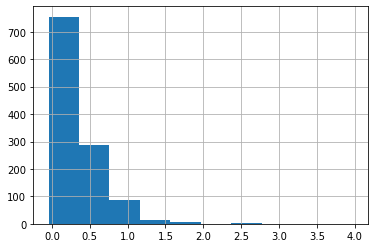

In [11]:
df[df.cusip == '882724SY4'].ytw.hist()

We clean up the data by removing trades with clearly wrong yields, although these are few enough in number that keeping them has no significant effect.

In [12]:
print(len(df))
df = df[ (df.ytw > 0) & (df.ytw < 3) ]
print(len(df))

41972
41903


Now we provide a unified interface for alternative ways of fitting a yield curve.

In [13]:
def fityc(t, y, method = "poly", param = None):
# fit an unweighted yield curve
    if method == "poly":
        if param is None: param = 3
        model = poly.Polynomial(poly.polyfit(t, y, deg=param)) 
    elif method == "NS":
        model, status = calibrate_ns_ols(t, y, tau0=4)
    elif method == "NSfixed":
        if param is None: param = 4
        model, lstsq_res = betas_ns_ols(param, t, y)
    else:
        print("unexpected method", method)
    return model

The optimal parameters of a Nelson-Siegel curve are very sensitive to outliers,
and it is easy for the optimal values to be unrealistic.
In particular, the parameter beta_0 is the asymptotic maximum interest rate; see https://onriskandreturn.com/2019/12/01/nelson-siegel-yield-curve-model/#more-488 for details.
Values over 5% are likely erroneous in the current environment of low rates.
To avoid these, we fix the time scale tau at four years.

In [14]:
y = np.array(df.ytw)
t = np.array(df.years)
fixedtau = 4

NScurve = fityc(t, y, "NS")
print(NScurve)
curve = fityc(t, y, "NSfixed", fixedtau)
print(curve)
ffit = fityc(t, y, "poly", 3)
print(ffit)

NelsonSiegelCurve(beta0=10.354272523494556, beta1=-9.838017533437379, beta2=-11.86333707083079, tau=10.064121545368852)
NelsonSiegelCurve(beta0=2.7662429272473634, beta1=-2.209049441684885, beta2=-3.588731924418716, tau=4)
poly([ 0.51419766 -0.09598081  0.02043585 -0.00060792])


The following functions let us visualize how well a model fits to data points with varying importance.
The weight of a point is proportional to the size of the trade, except that all trades above a certain threshold are equally important.

In [15]:
from matplotlib.colors import to_rgb, to_rgba

def drawpoints(df):
# plot points with transparency depending on size of trade
    r, g, b = to_rgb('purple')
    df = df[df.par_traded > 1e5]  # save time by not plotting points that would be invisible
    t = np.array(df.years)
    y = np.array(df.ytw)
    w = np.minimum( np.array(df.par_traded), 2e6)
    opacity = w/2e6
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(t, y, s=5, c=color)

def drawcurve(curve, label = "", maxyears=maxyears):
# plot predicted yields from a model
    t = np.linspace(0, maxyears, 100)
    plt.plot(t, curve(t), label = label)

def plotmodel(df,curve):
# plot datapoints and a model
    plt.figure()
    drawpoints(df)
    drawcurve(curve,"",np.max(np.array(df.years)))
    plt.xlabel("years")
    plt.ylabel("yield")

In the following plots of the three different models, notice that the Nelson_Siegel model with tau allowed to vary is visually almost indistinguishable from the polynomial model.
All the models should be used only for interpolation, i.e., only to estimate yields for maturities under twelve years.

CPU times: user 20.5 ms, sys: 37.1 ms, total: 57.6 ms
Wall time: 15 ms
CPU times: user 20.7 ms, sys: 53.8 ms, total: 74.5 ms
Wall time: 13.7 ms
CPU times: user 21.4 ms, sys: 57.7 ms, total: 79.1 ms
Wall time: 13.6 ms


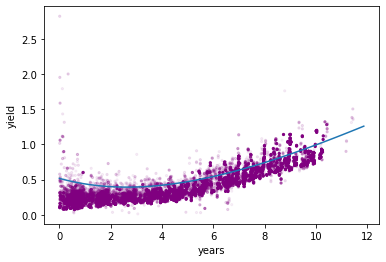

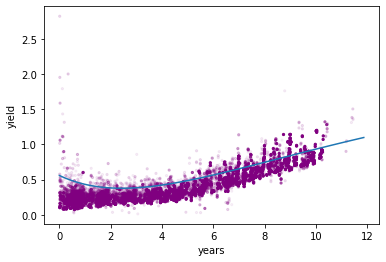

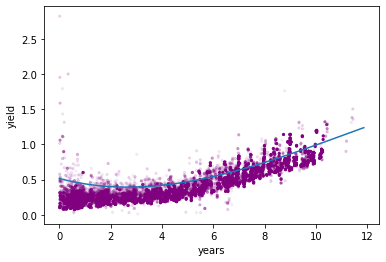

In [16]:
%time plotmodel(df,NScurve)
%time plotmodel(df,curve)
%time plotmodel(df,ffit)

In the plots above, there is an unexpected effect that yields appear to be lower around three years than more short-term.
To reduce the influence of small trades, we define our own function that does weighted least squares.
Each trade is weighted proportional to its size, i.e., the face value traded, up to a maximum of $5M per trade.

In [17]:
def wfityc(t, y, w = None, method = "poly", param = None):
# fit a yield curve with weights w
    if w is None: w = np.ones_like(t)
    _assert_same_shape(t, y)
    _assert_same_shape(t, w)
    
    if method == "poly":
        if param is None: param = 3
        model = poly.Polynomial(poly.polyfit(t, y, w=w, deg=param)) 
    elif method == "NSfixed":
#       Calculate beta values given fixed tau for times t and yields y with weights w
#       Adapted from https://github.com/luphord/nelson_siegel_svensson
#       Method from https://stackoverflow.com/questions/27128688/how-to-use-least-squares-with-weight-matrix
#       The so-called factors are basis function values.
        if param is None: param = 4
        curve = NelsonSiegelCurve(0, 0, 0, param)
        factors = np.array(curve.factor_matrix(t))
        factors = factors * np.sqrt(w[:,np.newaxis])
        y = y * np.sqrt(w)    
        lstsq_res = lstsq(factors, y, rcond=None)
        beta = lstsq_res[0]
        model = NelsonSiegelCurve(beta[0], beta[1], beta[2], param)
    else:
        print("unexpected method", method)
    return model

NelsonSiegelCurve(beta0=2.6953580347481356, beta1=-2.3953354507513946, beta2=-3.324920915295518, tau=4)
poly([ 0.20769724 -0.04642395  0.01854884 -0.00070346])


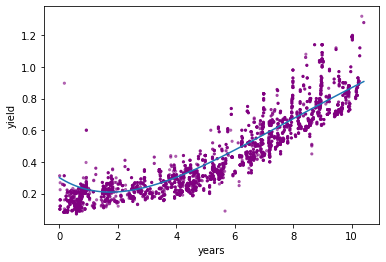

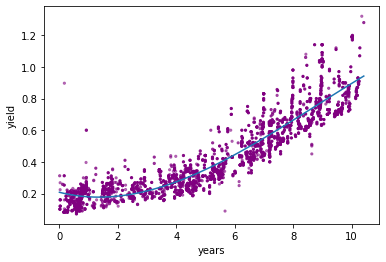

In [18]:
t = np.array(df.years)
y = np.array(df.ytw)
w = np.array(df.par_traded)
w = np.minimum(w,5e6)
avgcurve = wfityc(t, y, w, "NSfixed")
print(avgcurve)
plotmodel(df[df.par_traded>=1e6],avgcurve)

avgcurve = wfityc(t, y, w, "poly")
print(avgcurve)
plotmodel(df[df.par_traded>=1e6],avgcurve)

With trades weighted by notional size, estimated short-term yields are lower and both models are closer to monotonically increasing.
Showing only large trades reveals that the Nelson-Siegel shape is clearly not correct for the actual pattern of yields at the short end.

Next we look at how the yield curve changes from each day to the next day.
We define a function that is like an exponential moving average,
that updates a model using new trades.
If the weight v of the old model is less than 1, then this weight is relative.
If v is greater than 1, then it is an absolute weight, i.e., an equivalent volume traded measured in dollars.

In [19]:
def updateyc(old, v, t, y, w, method = "poly", param = None):
# let the old curve have relative or absolute weight v; update it using new observations
# the old model is converted into pseudo data points

    _assert_same_shape(t, y)
    _assert_same_shape(t, w)
    
    if (v > 1): target = v
    else: target = np.sum(w) * v / (1-v)
        
# the first set of pseudo data points is spaced equally
# this makes the new model stay close to the old model when away from the new data points
    eps = maxyears / len(t)
    grid = np.arange( 0, maxyears+eps, eps)
    gridy = old(grid)
    gridw = target * np.ones_like(grid) / len(grid)
    
# the second set is at the same locations as the new data points, with proportional weights
    oldy = old(t)
    oldw = target * w / np.sum(w)
    
    t = np.concatenate([grid,t,t])
    y = np.concatenate([gridy,oldy,y])
    w = np.concatenate([gridw,oldw,w])
    model = wfityc(t, y, w, method=method, param=param)
    return model

The following is an example of updating a model with three new data points.
Because there are no new observations near t=0 or t=10,
the new model is close to the old model towards these boundaries.

poly([ 2.07523097e-01  4.95566295e-03  2.41210501e-03  9.63739367e-04
 -5.65972021e-05])


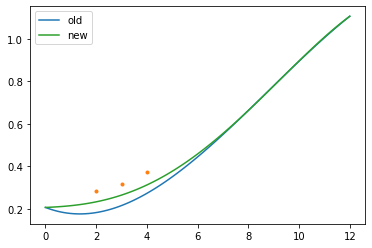

In [20]:
t = np.array(df.years)
y = np.array(df.ytw)
w = np.minimum( np.array(df.par_traded), 5e6)
method = "poly"
avgcurve = wfityc(t, y, w, method)
drawcurve(avgcurve, "old")

g = np.arange(2,5,1)
y = avgcurve(g) + 0.1
plt.plot(g,y,".")
newcurve = updateyc(avgcurve, 0.5, g, y, 1.0*np.ones_like(g), method, 4)
drawcurve(newcurve, "new")
plt.legend()
print(newcurve)

Finally we look at how the yield curve changes from day to day.
The first days of data are used for initialization, up to a threshold dollar volume.
Then, each day's data is used to update the previous curve.
The previous curve always has the given fixed weight.
The model is restricted to be quadratic because it is fitted to what is effectively much less data.

If the day's change in yield is large, information for the day is printed.
Each month, the full yield curve is plotted for the first day with sufficient cumulative volume on or after the 15th.

In [21]:
def ycreport(df, maxweight, maxone = 5e6, daily = True):
# describe the evolution of the yield curve based on trades in a dataframe
# daily = False means update the yield curve weekly
    print(np.sum(np.minimum( np.array(df.par_traded), maxone )))

    if daily: daylist = sorted(set(df.trade_date))
    else: daylist = sorted(set(df.trade_date.dt.week))
    curves = [0 for day in daylist]
    dayweight = [0 for day in daylist]
#    method = "NSfixed"; param = fixedtau
    method = "poly"; param = 2
    
    totalweight = 0
    
    plotted = [False for day in daylist]
    plt.figure()
    for i, day in enumerate(daylist):
        if daily: daydf = df[df.trade_date == day]
        else: daydf = df[df.trade_date.dt.week == day]
        t = np.array(daydf.years)
        y = np.array(daydf.ytw)
        w = np.minimum( np.array(daydf.par_traded), maxone )
        
        if (i==0): curve = wfityc(t, y, w, method, param)
        else: curve = updateyc(prev, totalweight, t, y, w, method, param)
            
        curves[i] = curve   
        dayweight[i] = np.sum(w)
        totalweight = min( totalweight+dayweight[i], maxweight )
        
        if (not daily) or (day.day in range(15,15+15) and not any(plotted[max(i-15,0):i+1]) and totalweight >= maxweight):
            if daily: drawcurve(curve, day.strftime('%b %d'))
            else: drawcurve(curve, str(day))
            plotted[i] = True
        prev = curve
    plt.xlabel("years")
    plt.ylabel("yield")
    plt.legend()
    
    shortchange = [0 for day in daylist]
    longchange = [0 for day in daylist]
    
    for i in range(3,len(daylist)):
        prev = curves[i-1]
        curve = curves[i]
        shortchange[i] = curve(1) - prev(1)
        longchange[i] = curve(10) - prev(10)
        if daily and (abs(shortchange[i]) >= 0.05 or abs(longchange[i]) >= 0.05):
            day = daylist[i]
            print(day, locale.currency( dayweight[i], grouping = True ), round(shortchange[i],2), round(longchange[i],2) )
            plt.figure()
            drawcurve(prev, daylist[i-1].strftime('%b %d'))
            drawpoints( df[(df.trade_date == day)])
            drawcurve(curve, day.strftime('%b %d'))
            plt.xlabel("years")
            plt.ylabel("yield")
            plt.legend()
            
    plt.figure()
    if daily: return [day.date() for day in daylist], longchange
    else: return daylist, longchange

First we look at how the yield curve evolves using data from all states.

5015402000.0
2020-11-19 00:00:00 $178,895,000.00 -0.02 -0.08
CPU times: user 218 ms, sys: 562 ms, total: 780 ms
Wall time: 142 ms


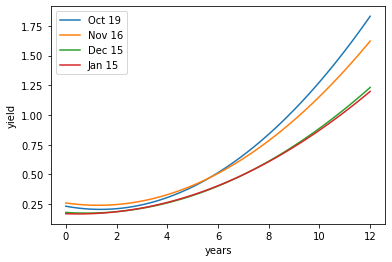

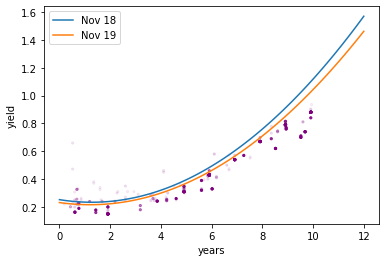

<Figure size 432x288 with 0 Axes>

In [22]:
%time (usd,usc) = ycreport(df,200e6,1e6, True)

Using trades from all states except California,
the upper plot above show that ten-year rates declined from mid October through November and December, then rose slightly to mid January. 
The lower plot shows a notable decrease in yields from November 18 to 19.
<!-- The following query shows the cause of this decline.
Over $47M was traded in two bonds with life over nine years from North Carolina and Maryland,
which are states with AAA credit ratings and hence low yields. -->

Now, if the yield curves we compute are reliable, they should be similar when using data from California
and when using data from all other states.

3964509000.0
2020-11-19 00:00:00 $168,105,000.00 -0.02 -0.08
CPU times: user 205 ms, sys: 441 ms, total: 645 ms
Wall time: 146 ms
1050893000.0
2020-11-05 00:00:00 $23,520,000.00 -0.01 -0.06
CPU times: user 190 ms, sys: 469 ms, total: 659 ms
Wall time: 133 ms


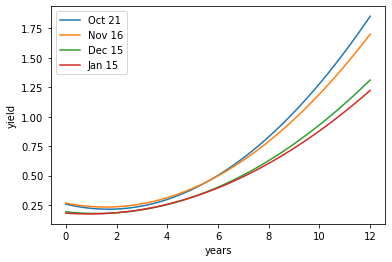

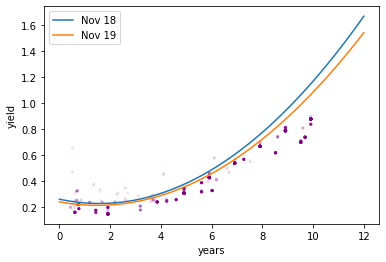

<Figure size 432x288 with 0 Axes>

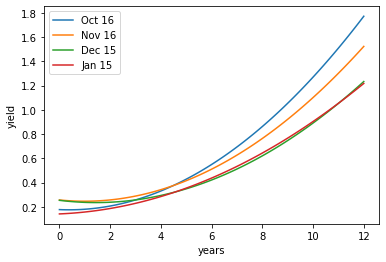

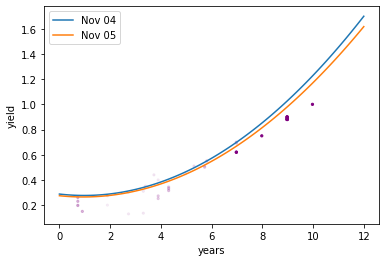

<Figure size 432x288 with 0 Axes>

In [23]:
%time (usd,usc) = ycreport(df[~(df.issuer == "CALIFORNIA")],200e6,1e6, True)
%time (cad,cac) = ycreport(df[df.issuer == "CALIFORNIA"],30e6,1e6, True)

The changes from month to month are similar above, but the days with largest change are different. Next, we superimpose the daily changes from each model.

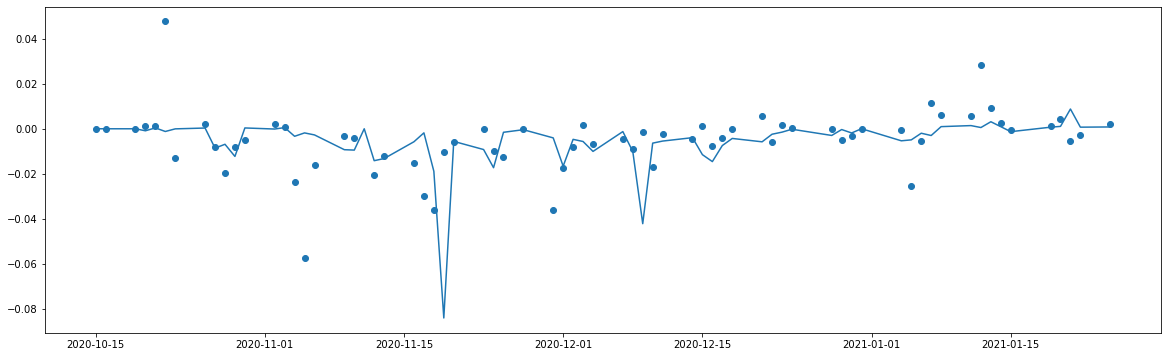

In [24]:
plt.figure(figsize=(20,6)) 
plt.plot(usd,usc)
plt.scatter(cad,cac)

Unfortunately, it is clear that the two models do not track each other well.
In particular, on the days where each one changes the most, the other one hardly changes at all.

The following function shows how the weighted average error in predicted yield depends on one or more predictors.
In order not to reduce the effective sample sizes too much,
all trades over $400,000 are weighted equally.
Smaller trades tend to happen at a higher yield (lower price), up to this threshold.

For example, consider the credit rating of the issuer and the years until maturity.
The average AAA trade is at a yield 2.1 points lower under two years,
and 6.4 points lower if two years or more.
The difference between these two numbers says that the AAA credit rating
is more important when owning a long-term bond, which makes sense.

In contrast, the average A+ trade is at a yield 8.1 points higher if short duration,
and 9.3 points higher if long duration.
Interestingly, on average bonds rated AA trade at lower yields than those rated AA+,
even though the latter rating is superior.

In [25]:
savedf = df.copy()
df['w'] = np.minimum(np.array(df.par_traded),4e5)
avgcurve = wfityc(df.years, df.ytw, df.w, "poly")

# compare how prediction errors depend on variables
def study(df,dim):
    df['ydiff'] = df.ytw - avgcurve(df.years)
    df['wdiff'] = df.ydiff * df.w    
    grandmean = df.wdiff.sum() / df.w.sum()
    g = df.groupby(dim)
    summary = g.mean()
    summary['wm'] = g.wdiff.sum() / g.w.sum() - grandmean
    summary['wm'] = round( 100 * summary.wm, 1 )
    summary['se'] = round( 100 * g.ydiff.sem(), 1 )
    summary['n'] = g.wdiff.count()
    return summary.drop(columns = ['delta','w','ydiff','wdiff'])[summary.n >= 20]

df['long'] = df.years > 2
study(df,['rating','long'])

ytw       price     par_traded     years   wm   se     n
rating long                                                                
A+     False  0.509764  104.276948  233804.855275  0.951325  8.1  0.8  1071
       True   0.582986  119.901673  160040.032026  4.676350  9.3  0.4  1249
AA     False  0.450828  104.543981  287524.891413  1.022811  1.7  0.5  2993
       True   0.508698  121.902088  268893.732970  5.082822 -2.2  0.2  5505
AA+    False  0.451335  104.129397  179609.737249  0.973716  3.8  0.4  3882
       True   0.501923  118.696663  185435.651353  4.552813 -0.3  0.2  6356
AA-    False  0.442509  104.606838  120471.569839  1.071432  3.8  0.5  3236
       True   0.584857  122.178159  445020.784498  5.490646  2.8  0.2  6399
AAA    False  0.417214  103.814545  310972.396487  0.893587 -2.1  0.4  4782
       True   0.464938  121.531852  434830.793157  5.072238 -6.4  0.2  6430

Now we use the same comparison method to see how much yields change from week to week.
First we create two different sets of states that are equally balanced for average yield.

In [26]:
# df['day'] = df.trade_date.dt.day_name()
# df['small'] = df.par_traded < 4e5

v = df.groupby('issuer').par_traded.sum().sort_values().reset_index()
v = df.groupby('issuer').rating.agg(pd.Series.mode).sort_values().reset_index()
v = study(df,['issuer']).wm.sort_values().reset_index()

half = set(v[0::2].issuer) 
half = half - {'MASSACHUSETTS', 'PENNSYLVANIA', 'FLORIDA', 'ARKANSAS'} | {'CALIFORNIA', 'MARYLAND'}
other = set(df.issuer) - set(half)
# print(len(half), np.sum(df[df.issuer.isin(half)].par_traded), half )
# print(len(other), np.sum(df[df.issuer.isin(other)].par_traded), other )
df['half'] = df.issuer.isin(half)

study(df,['half'])

,ytw,price,par_traded,years,long,wm,se,n
half,,,,,,,,
False,0.479254,113.874717,266366.650809,3.236751,0.593578,-0.1,0.1,21020
True,0.500470,115.340010,315497.294450,3.738563,0.644639,0.1,0.1,20883


Finally we look at the level of yields week by week, for the two different halves.
Unfortunately the pattern of movement is not very consistent.

In [27]:
df['week'] = df.trade_date.dt.week
study(df,['week','half']).head(50)

ytw       price     par_traded     years      long   wm   se  \
week half                                                                       
1    False  0.454252  114.555757  168442.675159  3.369501  0.633758 -3.5  0.5   
     True   0.456017  115.453990  412777.345919  3.740383  0.661299 -5.3  0.5   
2    False  0.493999  114.658799  216017.328116  3.441662  0.615428 -2.3  0.5   
     True   0.492489  116.435543  193458.461538  3.919581  0.690462 -2.2  0.5   
3    False  0.458817  114.194192  149242.658423  3.303230  0.616692 -2.3  0.5   
     True   0.477927  115.648128  128089.655172  3.704935  0.668966 -0.7  0.5   
4    False  0.463711  114.974773  136054.263566  3.391751  0.666667 -5.4  1.4   
     True   0.460286  114.581857  100040.572792  3.569465  0.677804 -3.9  1.0   
42   False  0.501315  113.542221  310218.855219  3.265366  0.574074  2.9  0.9   
     True   0.486524  114.583436  300817.669173  3.516852  0.590226  0.4  0.7   
43   False  0.498734  112.789103  363544.303797  3.010769  0.544304  4.4  0.5   
     True   0.550201  114.625200  620590.379009  3.648130  0.622449  7.5  0.6   
44   False  0.551656  113.067275  258069.784707  3.102393  0.569414  6.7  0.6   
     True   0.598070  115.049763  352848.011364  3.787103  0.632102  9.0  0.5   
45   False  0.554814  113.538895  237569.675090  3.236055  0.579783  7.7  0.6   
     True   0.588661  115.452133  275868.160844  3.888192  0.630191  7.7  0.5   
46   False  0.555897  113.171117  207723.642173  3.102411  0.587859  7.5  0.6   
     True   0.563250  114.662905  499650.000000  3.729755  0.629231  5.7  0.5   
47   False  0.466747  115.278648  338998.871968  3.525878  0.611957 -1.3  0.4   
     True   0.510339  116.015228  368158.896914  3.876854  0.657255 -0.4  0.5   
48   False  0.477728  114.655578  272200.980392  3.380827  0.630392  0.9  0.6   
     True   0.453549  115.082271  340918.546366  3.557985  0.659148 -2.1  0.7   
49   False  0.441646  113.571715  400786.184211  3.126728  0.596053 -2.6  0.5   
     True   0.483539  115.494984  384627.694317  3.863057  0.666231 -2.1  0.5   
50   False  0.433331  113.709838  530270.551509  3.186890  0.564516 -5.6  0.5   
     True   0.464709  114.983599  229659.730722  3.531152  0.599755 -2.5  0.5   
51   False  0.445443  113.559324  162532.975085  3.133795  0.593552 -1.3  0.4   
     True   0.460888  115.519356  228971.486762  3.726126  0.634929 -4.1  0.4   
52   False  0.465451  114.166186  148888.339921  3.283441  0.618577 -0.3  0.7   
     True   0.461250  115.764031  282391.479100  3.843505  0.676849 -4.3  0.5   
53   False  0.434019  112.138620  155669.431280  2.839534  0.509479 -1.1  0.6   
     True   0.455362  114.323299  162042.857143  3.465069  0.597802 -1.4  0.6   

               n  
week half         
1    False  1570  
     True   1801  
2    False  1789  
     True   1625  
3    False  1294  
     True   1305  
4    False   387  
     True    419  
42   False   594  
     True    532  
43   False  1264  
     True   1372  
44   False  1347  
     True   1408  
45   False  1385  
     True   1517  
46   False  1252  
     True   1300  
47   False  1773  
     True   1523  
48   False  1020  
     True    798  
49   False  1520  
     True   1531  
50   False  1922  
     True   1634  
51   False  2047  
     True   1964  
52   False  1012  
     True   1244  
53   False   844  
     True    910

We see above that there is a clear pattern: as desired, the delta in yields in each week tends to be similar 
for the two disjoint sets of states.
However, the consistency is not string enough to give confidence that we can estimate
an accurate yield curve on a daily basis.
In the future, we will investigate an alternative approach.